# PSTAT 134 Final Project - Restaurant Recommendation System
## Group Members - Victoria Chen, Stephanie Zacharias, Danny Baerman, Chau Tran

## Introduction

The main goal of this project is to create a model that recommends restaurants to users, based on personalised preferences of food, atmosphere and other potential desires. The data used for this project has been acquired from the Kaggle Yelp Dataset Challenge. This dataset comprises reviews of businesses from 11 metropolitan areas scattered over 4 different countries. This project will hone in specifically on reviews of restaurants located in Las Vegas, Nevada.

To build the restaurant recommendation system, the project applies text mining techniques to reviews of each restaurant in order to deduce what the restaurant is like. Our predictions and analysis of each restaurant will be matched with user defined preferences to give every user the optimal recommendation. This approach will ensure that users will have their needs met and have a pleasant dining experience every time.

## Exploratory Data Analysis and Visualization

In this section, EDA and meaningful visualizations will be used to develop a thorough and insightful understanding of the dataset.

### Setup: import packages 

In [1]:
import json
import pandas as pd
from collections import Counter

import numpy as np
import heapq
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

from scipy.cluster.hierarchy import linkage, leaves_list

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

from IPython.display import Image

### Import Data 

Due to limitations of computational power and time constratints of the project, we will only analyse businesses with at least 500 reviews.

In [2]:
# This takes some time to run, so we provide the filtered train_business.json file
#!pip install kaggle
#!kaggle datasets download yelp-dataset/yelp-dataset -p ./data/ --unzip
#! jq -c 'select(.review_count>500)' data/yelp_academic_dataset_business.json > train_business.json
! wc -l backup_data/train_business.json # Number of businesses with at least 500 reviews (1263)

    1263 backup_data/train_business.json


In [3]:
#Explore file format of train_business.json
!head -n1 backup_data/train_business.json | jq .

{
  "business_id": "jScBTQtdAt-8RshaiBEHgw",
  "name": "Served",
  "address": "1770 W Horizon Ridge, Ste 100",
  "city": "Henderson",
  "state": "NV",
  "postal_code": "89012",
  "latitude": 36.0107451,
  "longitude": -115.0648029,
  "stars": 4.5,
  "review_count": 664,
  "is_open": 1,
  "attributes": {
    "DriveThru": "False",
    "RestaurantsAttire": "'casual'",
    "NoiseLevel": "'quiet'",
    "RestaurantsGoodForGroups": "True",
    "WiFi": "'no'",
    "Alcohol": "u'beer_and_wine'",
    "WheelchairAccessible": "True",
    "DogsAllowed": "False",
    "BusinessAcceptsCreditCards": "True",
    "BusinessAcceptsBitcoin": "False",
    "GoodForMeal": "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}",
    "Caters": "True",
    "HasTV": "False",
    "RestaurantsTakeOut": "True",
    "RestaurantsTableService": "True",
    "BikeParking": "False",
    "RestaurantsReservations": "True",
    "RestaurantsDelivery": "False",
    "Restaurant

In [4]:
business = pd.read_json("backup_data/train_business.json", lines=True)
def is_restaurant(string):
    return "Restaurants" in string
business = business[business['categories'].apply(is_restaurant)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,jScBTQtdAt-8RshaiBEHgw,Served,"1770 W Horizon Ridge, Ste 100",Henderson,NV,89012,36.010745,-115.064803,4.5,664,1,"{'DriveThru': 'False', 'RestaurantsAttire': ''...","Ethnic Food, American (New), Burgers, Food, Re...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '..."
1,nsNONDHbV7Vudqh21uicqw,Salt Cellar,550 N Hayden Rd,Scottsdale,AZ,85257,33.454286,-111.909405,3.5,526,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Seafood, Restaurants","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
2,6fPQJq4f_yiq1NHn0fd11Q,La Creperie,3655 Las Vegas Blvd S,Las Vegas,NV,89109,36.112527,-115.171351,3.5,535,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...","French, Restaurants, Creperies","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."
3,dUffgo9Lh_Vk9TLuFR5ywg,Oregano's Pizza Bistro,1008 E Camelback Rd,Phoenix,AZ,85014,33.509510,-112.060238,3.5,563,1,"{'Alcohol': 'u'full_bar'', 'RestaurantsAttire'...","Restaurants, Pizza, Sandwiches, Italian","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
5,-bd4BQcl1ekgo7avaFngIw,Eggstasy,6990 E Shea Blvd,Scottsdale,AZ,85254,33.582508,-111.931220,3.5,646,1,"{'Ambience': '{'romantic': False, 'intimate': ...","Diners, Breakfast & Brunch, Restaurants","{'Monday': '6:30-15:0', 'Tuesday': '6:30-15:0'..."


### EDA and Visualization

Text(0.5, 1.0, 'Number of Restaurants Per State')

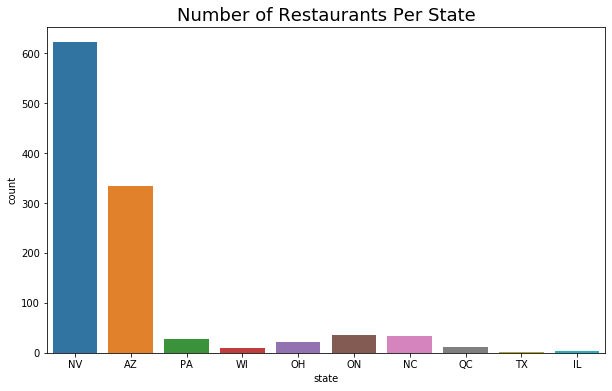

In [5]:
fig = plt.figure(figsize=(10,6))
sns.countplot(business["state"]).set_title('Number of Restaurants Per State',fontsize = 18)

Text(0.5, 1.0, 'Number of Restaurants Per City in Nevada')

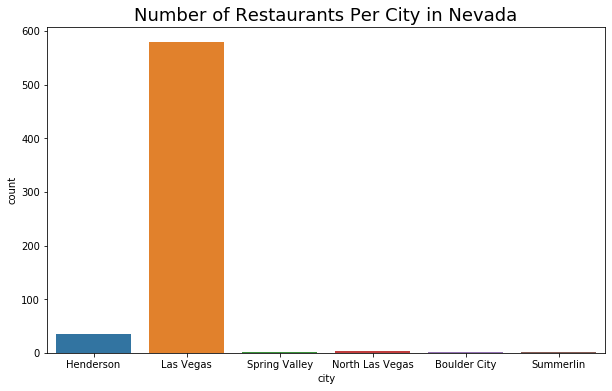

In [6]:
fig = plt.figure(figsize=(10,6))
sns.countplot(business["city"][business["state"]=="NV"]).set_title('Number of Restaurants Per City in Nevada',fontsize = 18)

Text(0.5, 1.0, 'Number of Restaurants for Each Rating')

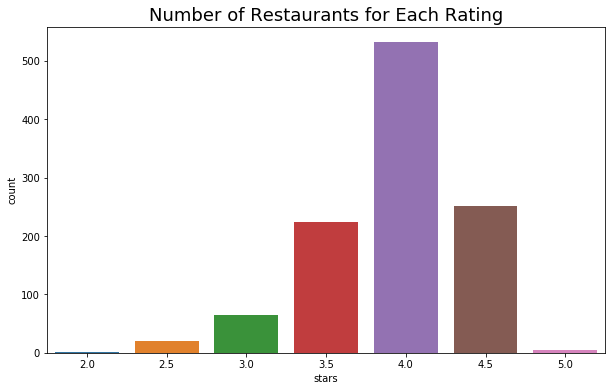

In [7]:
fig = plt.figure(figsize=(10,6))
sns.countplot(business['stars']).set_title('Number of Restaurants for Each Rating',fontsize = 18)

Text(0.5, 1.0, 'Most Popular Restaurant Categories')

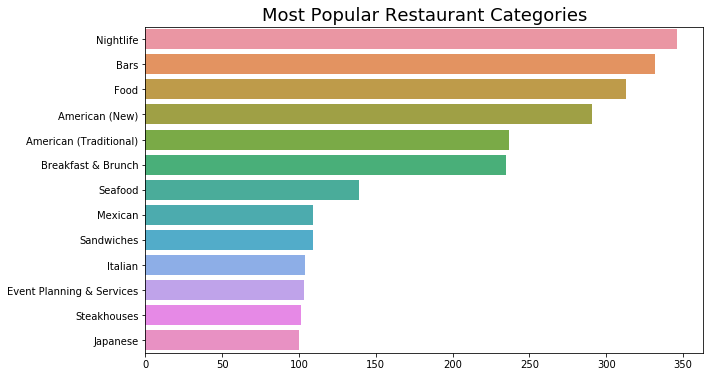

In [8]:
caterogies_list = business["categories"].str.cat(sep=', ')
caterogies_list = caterogies_list.split(", ")
caterogies_list, caterogies_counts  = np.unique(caterogies_list, return_counts=True)
caterogies_index = heapq.nlargest(55, range(len(caterogies_counts)), caterogies_counts.__getitem__)
caterogies_list[caterogies_index]
caterogies_counts[caterogies_index]
fig = plt.figure(figsize=(10,6))
(sns.barplot(y=caterogies_list[caterogies_index][1:14], x=caterogies_counts[caterogies_index][1:14])
 .set_title('Most Popular Restaurant Categories',fontsize = 18))

Since we are interested in building model for restaurants in Las Vegas, we take a look at their locations.

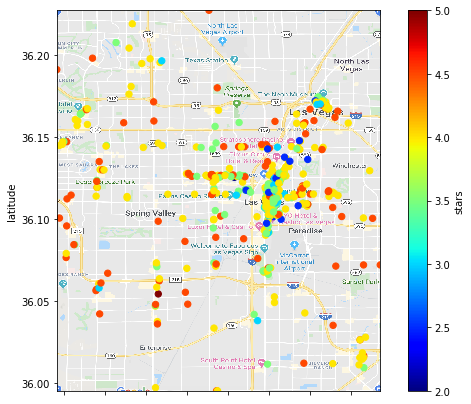

In [9]:
vegas_map = mpimg.imread("backup_data/vegas_map.png")


business_plot = business[(business["city"]=="Las Vegas")]
business_good = business_plot[business_plot["stars"]>4]
ax = business_plot.plot(kind="scatter", x="longitude", y="latitude", 
                        s=40,c="stars", colormap=plt.get_cmap("jet"), figsize=(10,7))

plt.imshow(vegas_map, extent=[-115.3042849441, -115.1070339563, 35.9951511, 36.2272411])

Since there is a mix of bad restaurants(3.5 stars or below) and good restaurants (4.5 stars or above), we want to look at good restaurants only.

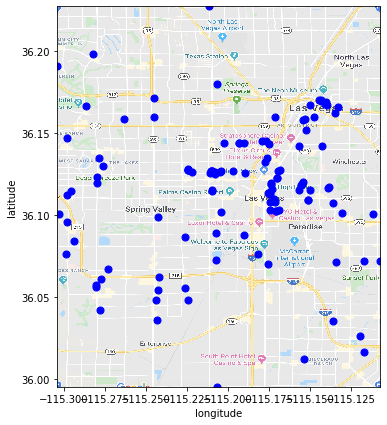

In [10]:
ax = business_good.plot(kind="scatter", x="longitude", y="latitude", 
                        s=50,c="blue", figsize=(10,7), colorbar=False)
plt.imshow(vegas_map, extent=[-115.3042849441, -115.1070339563, 35.9951511, 36.2272411])

The number of good restaurants are sufficient, and their locations are reasonably close for our project.

## Data Cleaning

In this section, we will explain how and why we filtered our data, and how our EDA contributed to our final subsetted dataset. 

We began our analysis with the following filtering conditions: 
- businesses that had at least 500 reviews
- businesses that classified as restaurants, cafes and bars

Subsequently, we plotted restaurants by state and the graph showed that the state of Nevada had the most data points. Within the state of Nevada, the city of Las Vegas had the most data pooints. We wanted to use the city with the most data points because it would ensure our analysis later on to be more accurate. 

Finally, we were interested to see how many restaurants there were at each star rating, and it was found that most restaurants had reviews higher than 4 stars. Hence, we decided to further restrict the data to restaurants that that had ratings higher than 4 stars.

In [11]:
business_subset = business[(business["city"]=="Las Vegas") & (business["stars"]>4)].reset_index(drop=True)
business_id = business_subset["business_id"].values
business_subset['review_count'].sum()

136044

In [12]:
len(business_id)

120

Since there are 136044 total reviews for these restaurant, we will only analyse 250 random reviews for each restaurant (30000 reviews total) due to limitations of computational powers. Moreover, we want to use good reviews for our study, so we will select reviews with 4 and 5 stars ratings.

In [13]:
# This takes a very long time to run(30+ minutes), so we provide the filtered subset_review.json file

# Create new subset_review.json file
#!rm subset_review.json
#!touch subset_review.json

# Filter out good review with star ratings higher or equal to 4 star
#! jq -c 'select(.stars>3.5)' data/yelp_academic_dataset_review.json > train_review.json

# Use grep to find the matching business_id and select 250 random reviews for each restaurant
#for id in business_id:
    #!grep -- $id ./train_review.json | shuf -n 250 >> ./subset_review.json

# Explore file format of subset_review.json
!head -n1 backup_data/subset_review.json | jq .

{
  "review_id": "8baVNVNy7Zl32ekZgrJj0Q",
  "user_id": "lT49-Xggq_VAB2E9dce0yA",
  "business_id": "Vs7gc9EE3k9wARuUcN9piA",
  "stars": 5,
  "useful": 3,
  "funny": 1,
  "cool": 1,
  "text": "This place offers a great variety of Asian dishes nicely prepared and served.  \n\nI always order my favorite Pad-See-Yeew with a Thai Ice tea, but I also love their chicken panang Curry and papaya salad.  The portions are great for sharing or as your own. \n\nThe service is always great and being family owned you can tell they have pride in what comes out of their kitchen.  Also  check out their great lunch specials, and desserts.",
  "date": "2013-12-26 23:10:51"
}


We will combine all 250 reviews that each restaurant has as a long review for each restaurant.

In [14]:
reviews = pd.read_json("backup_data/subset_review.json", lines=True)
reviews = reviews.loc[:,["business_id", "text"]]
reviews = reviews.groupby("business_id")["text"].unique().reset_index()
reviews["text"] = reviews["text"].str.join(' ')

In [15]:
business_reviews = business_subset[["name", "business_id"]].merge(reviews)[["name","text"]]
business_reviews

,name,text
0,Pan Asian,This place offers a great variety of Asian dis...
1,Buldogis Gourmet Hot Dogs,Being a foodie I always have high expectations...
2,Fountains of Bellagio,Bellagio's gift back to the community. It is g...
3,Egg Works,Got the biscuits and gravy... The sausage grav...
4,Chica,This place is outstanding! From the Chica Rit...
...,...,...
115,Egg Works,Went to breakfast here with my fiance and we r...
116,Grouchy John's Coffee,I tried this place when they had a truck on ca...
117,Egg & I,Oh don't get me started on the fresh baked muf...
118,Ramen Tatsu,"I ordered the spicy miso ramen w/ egg, which w..."


## Discussion of Approach and Methods
### Non-negative Matrix Factorization

For out text analysis, we chose to use Non-negative Matrix Factorization.

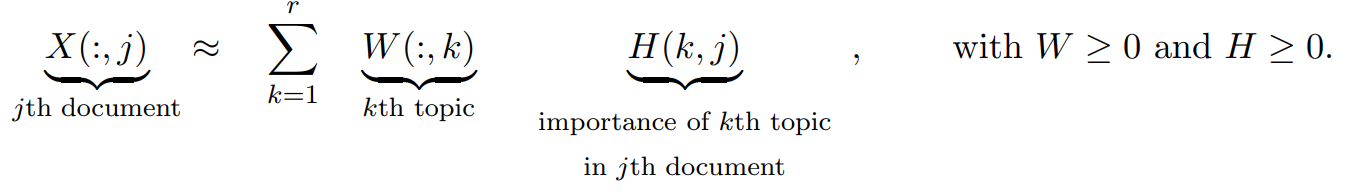

In [16]:
Image("backup_data/nmf-topics.png")

From **Algorithmic Aspects of Machine Learning** by **Ankur Moitra** we can interpret the nonnegative matrix factorization $X = WH$ as follows: Each document is itself a distribution on words, and what we have found is:

(1) A collection of r topics – the columns of $W$ – that are themselves distributions on words

(2) For each document i, a representation of it – given by $H_i$ – as a convex combination of r topics


### TF-IDF Model

NMF requires a TF-IDF matrix as input. TF-IDF is short for term frequency–inverse document frequency. Term Frequency measure the frequency that a word appears in all of the documents. Inverse Document Frequency measure how much information the word provides.

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', min_df=0.2, max_df=0.8)
tfidf = tfidf_vectorizer.fit_transform(business_reviews['text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
len(tfidf_feature_names)

2502

### Topic Modeling

In [18]:
## Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

# page 246
r = 10 # no. of topics
W_topic10,H_topic10 = \
    non_negative_marix_decomp(n_components = r, train_data = tfidf.T)
print(W_topic10.shape)
print(H_topic10.shape)

(2502, 10)
(10, 120)


We can get 10 topics from matrix $W$ and their distributions of keywords.

In [19]:
def extract_topic_top_words(W, all_words, num_top_words=10):
    
    num_words, num_topics = W.shape
    
    assert num_words == len(all_words)
    
    for t in range(0, num_topics):
        top_words_idx = np.argsort(W[:,t])[::-1]  # descending order
        top_words_idx = top_words_idx[:num_top_words]
        top_words = [all_words[k] for k in top_words_idx]
        top_words_shares = W[top_words_idx, t]
        print('# Topic', t+1)
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            print(word, share)
        print('\n')
        
extract_topic_top_words(W_topic10, tfidf_feature_names)

# Topic 1
lobster 0.38194802370103365
steak 0.35828552334875247
wine 0.26421348172838494
filet 0.24200700896666533
crab 0.21729090928281597
bread 0.18891556275543273
lamb 0.18724739018104672
potatoes 0.1751447316816897
steaks 0.161707413082243
cake 0.14938476992289995


# Topic 2
sushi 1.6506056728387477
fish 0.3805731913021276
roll 0.3585577560555743
sashimi 0.32129298002664997
rolls 0.3179264880028274
tuna 0.2488186757543006
ayce 0.23371008035260774
salmon 0.18857654690089473
sake 0.17187804253716862
japanese 0.16940603622506217


# Topic 3
breakfast 1.215662202563179
eggs 0.4038241890286821
toast 0.353072386451249
egg 0.3264798131682945
omelette 0.3076415406877924
pancakes 0.3016429169610836
banana 0.30045965305414085
potatoes 0.2720106588184576
hash 0.2651221565190668
nut 0.25783394835744516


# Topic 4
thai 1.3091714449641467
curry 0.4942898626337464
duck 0.19852989348525815
rice 0.1762635470858541
noodles 0.1304578296838298
shrimp 0.12209793268801422
basil 0.10242436176292051
sou

We can get convex combination of 10 topics from matrix $H$.

In [20]:
num_topics, num_reviews = H_topic10.shape

H10df = pd.DataFrame(H_topic10, 
                     index=['topic'+str(one) for one in range(1, num_topics+1)], 
                     columns=['business'+str(one) for one in range(1, num_reviews+1)])
H10df

,business1,business2,business3,business4,business5,business6,business7,business8,business9,business10,...,business111,business112,business113,business114,business115,business116,business117,business118,business119,business120
topic1,0.000000,0.000000,0.103546,0.000000,0.260426,0.000000,0.00000,0.040603,0.000000,0.293592,...,0.030019,0.353220,0.567742,0.000000,0.011672,0.000000,0.000000,0.018552,0.000000,0.000000
topic2,0.000000,0.000000,0.000000,0.000000,0.005162,0.000000,0.00000,0.000000,0.013939,0.031442,...,0.007366,0.036984,0.002327,0.490261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic3,0.000000,0.014693,0.000000,0.553637,0.068741,0.014843,0.00000,0.004230,0.000000,0.000000,...,0.001698,0.000000,0.000000,0.002221,0.398195,0.546491,0.000000,0.544147,0.000000,0.000000
topic4,0.541804,0.000000,0.000000,0.001377,0.000000,0.000000,0.00000,0.000000,0.015569,0.037185,...,0.000711,0.000000,0.000000,0.000000,0.000000,0.001966,0.000000,0.001492,0.000000,0.000000
topic5,0.000000,0.057826,0.000000,0.003777,0.011031,0.399980,0.00000,0.006208,0.317078,0.005300,...,0.122663,0.000000,0.000000,0.017180,0.000000,0.004778,0.000027,0.001854,0.000000,0.348623
topic6,0.000000,0.060086,0.009803,0.000168,0.310777,0.000000,0.00000,0.465044,0.009573,0.025825,...,0.019485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic7,0.000000,0.000000,0.013966,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.009458,0.000000,0.040133,0.000000,0.291193,0.000000,0.583651,0.000000,0.000000,0.000000
topic8,0.000000,0.134235,0.000000,0.000000,0.113801,0.000000,0.00000,0.000000,0.000000,0.009765,...,0.000000,0.000000,0.000000,0.000000,0.048078,0.000000,0.000000,0.001982,0.000000,0.187147
topic9,0.144960,0.012805,0.035502,0.000000,0.043735,0.092859,0.00000,0.017809,0.024030,0.044414,...,0.027103,0.000000,0.042791,0.000000,0.000000,0.000000,0.000000,0.000000,0.504901,0.000000
topic10,0.000000,0.000000,0.030669,0.027543,0.000000,0.014970,0.71057,0.000000,0.354677,0.000642,...,0.106234,0.000000,0.000000,0.000000,0.007776,0.000000,0.000000,0.000000,0.000000,0.000000


We use the correlation matrix to see the similarity of topics between restaurants.

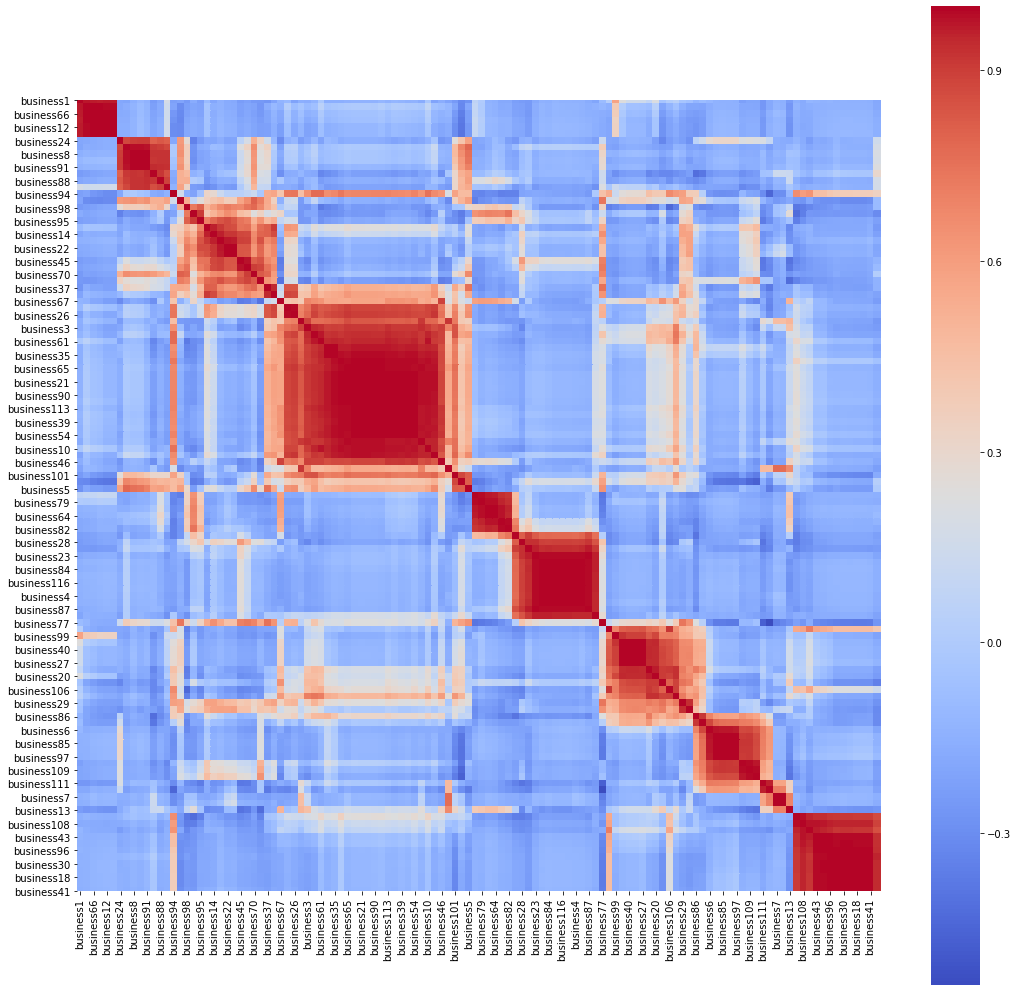

In [21]:
corr_matrix = H10df.corr()
review_linkage = linkage(corr_matrix.transpose(), optimal_ordering=True)
leave_ord = leaves_list(review_linkage)

plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix.iloc[leave_ord, leave_ord], square=True, cmap="coolwarm")

### Recommendation System
The user can choose between recommendation by topic, i.e. Korean BBQ, Steakhouse, or by similarity with their favorite business.

In [22]:
business_list = business_subset.loc[:,["name", "latitude", "longitude"]]

In [23]:
def business_recommendation(method, number_of_recommedations, topic_matrix, corr_matrix, business_list, res_name=None, choice=None):
    
    if method=="topic":
        print("Your Choice: " + str(choice))
        choice = choice - 1
        business = topic_matrix.iloc[choice,:]
        idx = heapq.nlargest(number_of_recommedations, range(len(business)), business.__getitem__)
 
    if method=="favorite":
        print("Your Favorite Restaurant: " + res_name)
        business_index = business_list[business_list["name"] == res_name].index[0]
        business = corr_matrix.iloc[business_index,:]
        idx = heapq.nlargest(number_of_recommedations, range(len(business)), business.__getitem__)
    
    top10 = pd.DataFrame()
    print("Top "+ str(number_of_recommedations)+" Recommended Business:")
    n=1
    for i in idx:
        print(str(n) + "." +  business_list.loc[i,"name"])
        top10 = top10.append(business_list.iloc[i])
        n = n+1
    #Show locations
    #ax = top10.plot(kind="scatter", x="longitude", y="latitude", 
                        #s=100,c="rank", colormap=plt.get_cmap("jet"), figsize=(10,7))
    plt.figure(figsize=(20,14))
    ax = plt.scatter(top10.longitude, top10.latitude)
    for i, (label, x, y) in enumerate(zip(top10.name, top10.longitude, top10.latitude)):
        plt.annotate(
        str(i+1),
        xy=(x, y), xytext=(0, 0),
        textcoords='offset points', ha='right', va='bottom', color="white", size=15,
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=1),
        arrowprops=dict(facecolor="white"))
    #long = top10["longitude"]
    #lat = top10["latitude"]
    #for i, txt in enumerate(top10rank):
        #ax.annotate(txt, (long[i], lat[i]))
    plt.imshow(vegas_map, extent=[-115.3042849441, -115.1070339563, 35.9951511, 36.2272411])

We can see **Topic 2** is about **Japanese Food** and **Topic 5** is about **Korean BBQ**. We will use these twos topics to test our recommendation system.

Your Choice: 2
Top 10 Recommended Business:
1.Naked Fish's Sushi & Grill
2.Sapporo Revolving Sushi
3.Sushi Way
4.Sakana
5.Kaizen Fusion Roll and Sushi
6.Jjanga Steak & Sushi
7.Kabuto
8.Sen of Japan
9.Soho Japanese Restaurant
10.Pier 215


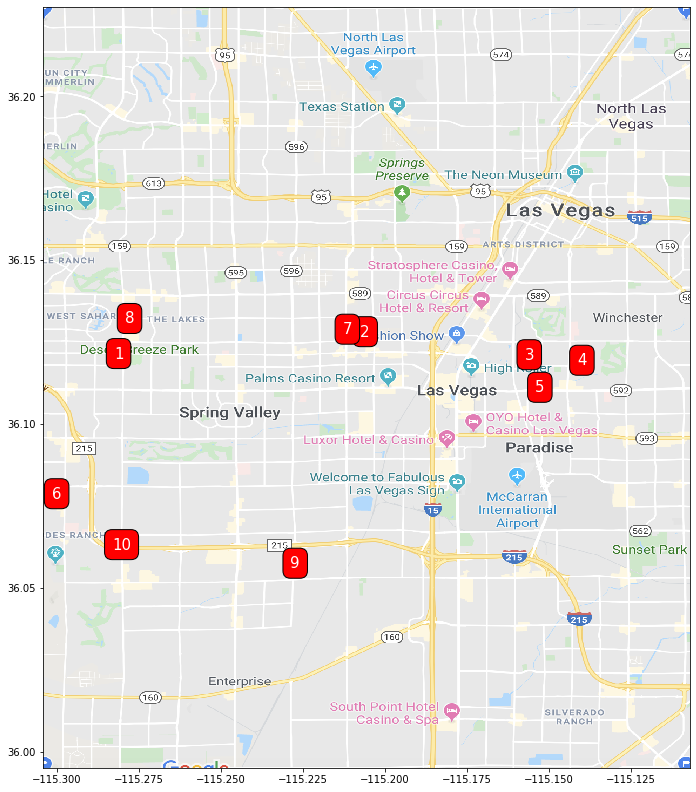

In [24]:
choice = 2
business_recommendation(method="topic", 
                        number_of_recommedations=10, 
                        topic_matrix=H10df, corr_matrix=corr_matrix, 
                        business_list=business_list,
                        choice=choice)

Your Favorite Restaurant: Sushi Way
Top 10 Recommended Business:
1.Sushi Way
2.Naked Fish's Sushi & Grill
3.Kaizen Fusion Roll and Sushi
4.Sakana
5.Jjanga Steak & Sushi
6.Sapporo Revolving Sushi
7.Kabuto
8.Sen of Japan
9.Soho Japanese Restaurant
10.Pier 215


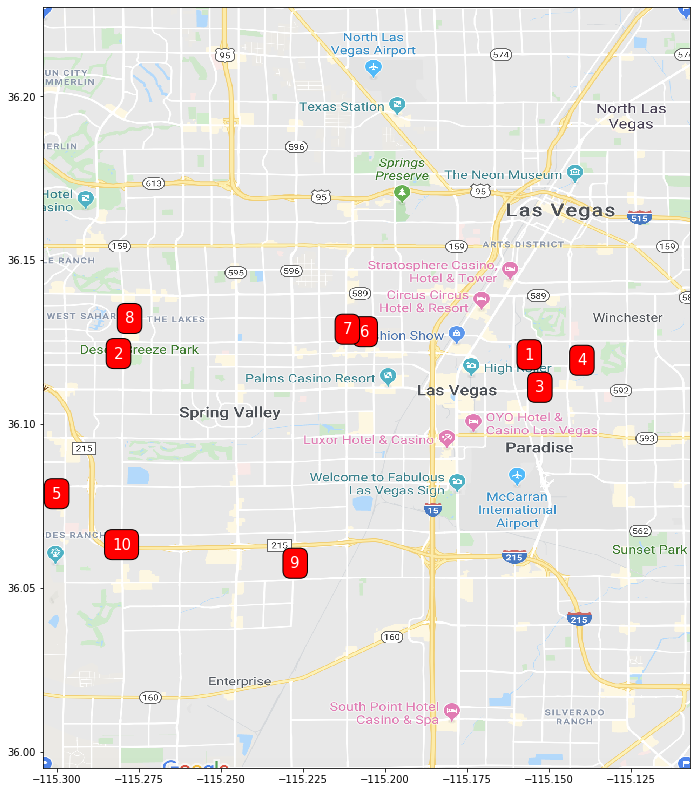

In [25]:
res_name = "Sushi Way"
business_recommendation(method="favorite", 
                        number_of_recommedations=10, 
                        topic_matrix=H10df, corr_matrix=corr_matrix, 
                        business_list=business_list,
                        res_name=res_name)

The system works well with reasonable recommendations for both topics with their locations similar to Yelp System.

## Discussion of Results

Point 1:
- Our recommender system was generated through Non-Negative Matrix Factorization (NMF). Through topic modelling, we were able to deduce specific attributes of these restaurants.  Our most significant topics mainly revealed the categories of food offered at each restaurant, e.g. steaks, pastas, wines, coffees, etc.
- We also previously computed the most popular restaurant categories. The results indicated that our topic modelling results are in correspondance with the most popular restaurant categories. This means that our results from NMF were optimal, so we proceeded to build a recommendation system. 

Point 2:
- The correlation matrix allows us to identify which reviews are correlated, i.e. which reviews are discussing the same topics. This allows us to identify similar restaurants and give recommendations to users based on what they like. 

Point 3:
- The results obtained from our recommender system suggest that this system is reliable and accurate. For instance, inputting Asian-style restaurants yields several other Asian-style restaurants as recommendations.

Point 4: 
-   Our correlation matrix addresses the correlations between restaurants, i.e. restaurant $a$'s reviews are combined into one document which is either correlated or uncorrelated with restaurant $b$'s reviews. Perhaps a more common strategy when conducting NMF is to discern correlations between individual reviews themselves. 

    Comparing individual reviews may yield different results. By comparing individual reviews, we may grasp a better sense of what specific reviewers personally like to discuss. For instance, if user $a$ likes to talk about topics such as atmosphere or ambience in their review, we may find correlations between other reviewers who like to talk about atmosphere and ambience. 
    
       Observe that the ten topics we modelled tend to revolve around only food. Topic 1 concerns steaks and seafood, Topic 2 concerns Japanese food, Topic 3 concerns breakfast food, etc. No topic comprises observations of atmosphere, service quality, ambience, etc. This is likely explained by our strategy of comparing business reviews as a whole. If most reviews are about the food, then we can only generalize topics about the food. Consider that user $x$ chose to review the atmosphere and ambience of restaurant $x$. Because so many of restaurant $x$'s reviews are about the food, user $x$'s atmosphere review goes largely ignored. Suppose we were to analyze correlations between individual reviews. We would find correlations between user $x$'s reviews and other reviews concerning atmosphere of restaurants.
       
       This strategy of finding correlations between individual reviews comes with limitations however. Suppose some reviews are much longer than others. It may be difficult to find strong correlations, due to the fact that the data will largely be noisy.

## Possible Improvements and Future Directions

One considerable setback we faced in this project was limited computational power. This meant that we had to subset our data to create a feasible project. For instance, many of the restaurants had a large number of reviews, e.g. ~5000 reviews. By restricting our text mining to a random 250 reviews per restaurant, we were able to save time by using less computational power.  This likely didn't yield results as accurate as text mining 5000 reviews per restaurant would have.

Point 1:

In the future, with more resources, we can work with bigger datasets. Ideas/examples:
- Include analysis of businesses that are categorised as nightclubs or stores and give users a personalised Vegas experience. That is, we could create a model that recommends a breakfast restaurant to start the day, a shopping center to spend the afternoon in, and a brewery to end the night in.

- Analyze businesses for other large metropolitan areas, e.g. New York. 

Point 2:

While conducting this project, we proposed several other ideas for how to create our recommender system. One potential model consisted of creating a correlation matrix between reviews. Consider, for instance, review $a$ and review $b$ are correlated. We check to see if user $a$ and user $b$ both left 5 star reviews.  From there, we assume that if user $a$ and $b$ discussed topic $x$ in their reviews and left high star ratings, both user $a$ and $b$ enjoy topic $x$. We would then recommend user $b$'s favorite restaurants to user $a$.


Point 3:

Improve current recommendations by adding more features/criterias. For instance: 
- if the chosen restaurant is closed, show me the closest restaurant within 2 miles.
- Show me restaurants that are pet-friendly and have disability access. 


## Conclusion

The aim of our project was to use text mining techniques in order to create a restaurant recommender system. The data used for this project consisted of reviews of restaurants in Las Vegas, Nevada. We implemented Non-Negative Matrix Factorization on user reviews for restaurants, cafes and bars to generate topic modelling. The topic modelling results formed the backbone of our restaurant recommender system. The results obtained from our recommender system suggest that this system is reliable and accurate. For instance, inputting Asian-style restaurants yields several other Asian-style restaurants as recommendations. Furthermore, faced with limited computational power, we acknowledge that there are several possible improvements and future directions.

Text mining techniques can be applied to several types of text-based datasets. The techniques learned in this class provide a foundation for future research in data careers/education. The practice of Non-Negative Matrix Factorization allows data scientists to identify trends in text-based data, e.g. discern what topics are prevalent in the data, and create models that illuminate what these trends are.

## Reference
1. *Yelp Dataset*, https://www.yelp.com/dataset
2. *Algorithmic Aspects of Machine Learning* by **Ankur Moitra**. http://people.csail.mit.edu/moitra/docs/bookexv2.pdf
3. *Topic Modeling with Scikit Learn* by **Aneesha Bakharia** .https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730